# Expected Loss: Inaccuracy from Rasterization

As we are using a rasterizer in most public Notebooks right now, I want to stress the importance of the raster size w.r.t. the expected loss that originates from the rasterization inaccuracy.

Each history position, each lane, each other agent is encoded into a pixels and our net is only able to predict the next positions on the map with pixel accuracy. 
In many notebooks, the raster has a size of 0.50 m per pixel (hyperparameter). Thus, the expected mean error will be a 0.50 / 4 for each direction for each predicted position.

In the following I will calculate the resulting error in the given metric.

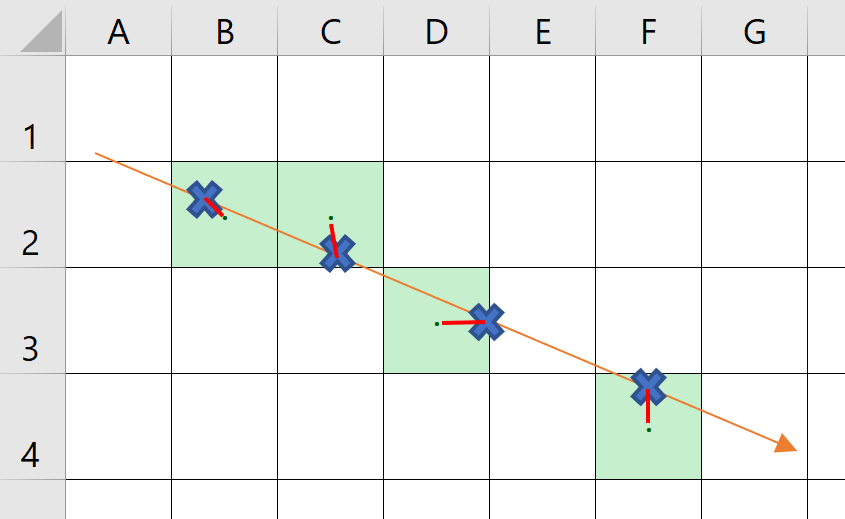
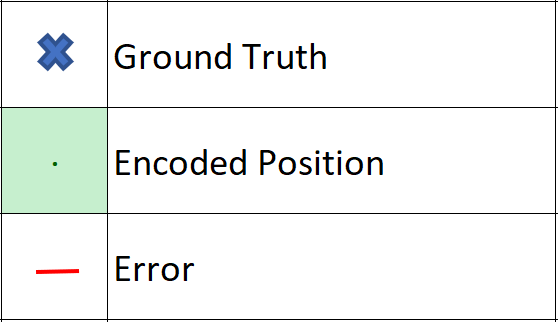

In [ ]:
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
# Thanks for the additions from here: https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence
import numpy as np
import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood(gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (time)x(2D coords)
        pred (Tensor): array of shape (modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 3, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (num_modes,), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert abs(torch.sum(confidences).item() - 1.0) < 1e-6, "confidences should sum to 1"
    assert avails.shape == (future_len,), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    gt = torch.unsqueeze(gt, 0)  # add modes
    avails = avails[None, :, None]  # add modes and cords

    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    max_value = error.max()  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1)) - max_value  # reduce modes
    return error


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)


In [ ]:
import pandas as pd
import numpy as np
from torch import Tensor

# 'pixel_size': [0.50, 0.50],
# so we must accept an error of up to 0.25 meter, mean error is 0.50 m / 4

submission = pd.read_csv("/kaggle/input/lyft-motion-prediction-autonomous-vehicles/single_mode_sample_submission.csv")

gt = Tensor(submission.iloc[0, 5:105].to_numpy().reshape((-1, 2)))
pred = Tensor(submission.iloc[0, 5:105].to_numpy().reshape((-1, 2)))
avails = Tensor(np.ones((50)))

gt = gt.unsqueeze(0)
pred = pred.unsqueeze(0)
avails = avails.unsqueeze(0)

pred += (0.50 / 4)

nll = pytorch_neg_multi_log_likelihood_single(gt, pred, avails)
print(f'Additional Expected Error for pixel_size = 0.50 (nll metric): {nll.item()}')

### Seems like we have to expect, that 0.78125 of our metric is actually just the inaccuracy from the rasterizer

In [ ]:
gt = Tensor(submission.iloc[0, 5:105].to_numpy().reshape((-1, 2)))
pred = Tensor(submission.iloc[0, 5:105].to_numpy().reshape((-1, 2)))
avails = Tensor(np.ones((50)))

gt = gt.unsqueeze(0)
pred = pred.unsqueeze(0)
avails = avails.unsqueeze(0)

pred += (0.25 / 4)

nll = pytorch_neg_multi_log_likelihood_single(gt, pred, avails)
print(f'Additional Expected Error for pixel_size = 0.25 (nll metric): {nll.item()}')

### We can reduce that value to 0.1953125 by creating a smaller grid (e.g. pixel_size = 0.25). Keep in mind, that you would need to double the raster_size to see the same region of the map.